In [1]:
import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.manifold import TSNE
import seaborn as sns
from torch.utils.data import Dataset

In [2]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from skimage import io

In [3]:
import albumentations as A
import torch
from albumentations.pytorch.transforms import ToTensorV2


def get_train_transform():
    return A.Compose([
        A.Flip(p=0.5),
        A.Rotate(p=1),
        A.Transpose(p=0.5),
        A.RandomBrightness(p=0.5),
        A.RandomContrast(p=0.5),
        ToTensorV2(p=1.0)
    ])

def get_test_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ])

In [4]:
# https://avandekleut.github.io/vae/

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
batch_size = 128
nchannels = 3

In [7]:
def z_score(img):
    avg = np.mean(img)
    std = np.std(img)
    img = (img - avg) / std
    return img

def z_score_arr(arr):
    arr = np.moveaxis(arr, 1, 0)
    avg = [np.mean(x) for x in arr]
    std = [np.std(x) for x in arr]
    arr = np.array([(arr[i] - avg[i])/std[i] for i in range(len(arr))])
    return np.moveaxis(arr, 0, 1), avg, std

def un_z_score(img, avg, std):
    img = np.array([img[i] * std[i] + avg[i] for i in range(len(img))])
    return img
    

In [8]:
class DatasetTrain(Dataset):

    def __init__(self, arr, transforms=None):
        super().__init__()
        self.arr = arr
        self.transforms = transforms

    def __getitem__(self, index: int):
        img = self.arr[index]
        img = np.array([z_score(ch) for ch in img])
        
        img = np.moveaxis(img, 0, -1)

        if self.transforms:
            img = self.transforms(image=img)['image']

        return img, 1

    def __len__(self) -> int:
        return len(self.arr)

In [9]:
path = '/research/sharedresources/cbi/public/data/hackathon_data/cell_crops_for_anna_v1.np.npy'
arr = np.load(path)
arr2, avg, std = z_score_arr(arr)
arr.shape, avg, std

((473, 3, 128, 128),
 [0.90952355, 0.8496768, 0.7957951],
 [0.087221384, 0.1281588, 0.1543755])

In [10]:
data = torch.utils.data.DataLoader(
        DatasetTrain(arr, transforms=get_train_transform()),
        batch_size=batch_size,
        shuffle=True)

data_test = torch.utils.data.DataLoader(
        DatasetTrain(arr, transforms=get_test_transform()),
        batch_size=batch_size,
        shuffle=True)

/research/sharedresources/cbi/common/Anna/anaconda3/envs/quamd/lib/python3.9/site-packages/albumentations/augmentations/transforms.py:1800: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/research/sharedresources/cbi/common/Anna/anaconda3/envs/quamd/lib/python3.9/site-packages/albumentations/augmentations/transforms.py:1826: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


In [11]:
class ConvLayerNorm(nn.Module):
    def __init__(self, ch_in, ch_out, ks, stride, padding):
        super(ConvLayerNorm, self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, ks, stride, padding),  
            nn.BatchNorm2d(ch_out),
            torch.nn.LeakyReLU(inplace=True),
            # torch.nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.layer(x)
    
    
class ConvLayer(nn.Module):
    def __init__(self, ch_in, ch_out, ks, stride, padding):
        super(ConvLayer, self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, ks, stride, padding),  
            torch.nn.LeakyReLU(inplace=True),
        )

    def forward(self, x):
        return self.layer(x)
    
    
    
class ConvTransposeLayer(nn.Module):
    def __init__(self, ch_in, ch_out, ks, stride, paddingm, output_padding=0):
        super(ConvTransposeLayer, self).__init__()
        self.layer = nn.Sequential(
            nn.ConvTranspose2d(ch_in, ch_out, ks, stride, 
                               padding=padding, output_padding=output_padding),
            torch.nn.LeakyReLU(inplace=True),
        )

    def forward(self, x):
        return self.layer(x)

    
class ConvTransposeLayerNorm(nn.Module):
    def __init__(self, ch_in, ch_out, ks, stride, padding, output_padding=0):
        super(ConvTransposeLayerNorm, self).__init__()
        self.layer = nn.Sequential(
            nn.ConvTranspose2d(ch_in, ch_out, ks, stride, 
                               padding=padding, output_padding=output_padding),
            nn.BatchNorm2d(ch_out),
            torch.nn.LeakyReLU(inplace=True),
            # torch.nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.layer(x)

In [12]:
class Encoder(nn.Module):
    def __init__(self, nchannels):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            # ConvLayerNorm(nchannels, 8, ks=7, stride=1, padding=0),
            # nn.MaxPool2d(2, stride=2, padding=1),  
            # ConvLayerNorm(8, 16, ks=3, stride=1, padding=0),
            # nn.MaxPool2d(2, stride=2, padding=0),  
            # ConvLayerNorm(16, 32, ks=3, stride=1, padding=0),
            # nn.MaxPool2d(2, stride=2, padding=0),  
            # ConvLayerNorm(32, 32, ks=3, stride=1, padding=1),
            # nn.MaxPool2d(2, stride=2, padding=1),  
            
            # ConvLayerNorm(nchannels, 8, ks=7, stride=3, padding=1),
            # ConvLayerNorm(8, 16, ks=5, stride=3, padding=1),
            # ConvLayerNorm(16, 32, ks=3, stride=1, padding=0),
            # ConvLayerNorm(32, 32, ks=3, stride=1, padding=0),
            # ConvLayerNorm(32, 32, ks=3, stride=1, padding=0),
            
            ConvLayerNorm(nchannels, 8, 5, stride=1, padding=1),
            ConvLayerNorm(8, 16, 3, stride=1, padding=0),
            nn.MaxPool2d(2, stride=2, padding=0),
            ConvLayerNorm(16, 24, 3, stride=1, padding=0),
            nn.MaxPool2d(2, stride=2, padding=0),
            ConvLayerNorm(24, 32, 3, stride=1, padding=0),
            nn.MaxPool2d(2, stride=2, padding=0),
        )

    def forward(self, x):
        return self.encoder(x)
    
class MLP_down(nn.Module):
    def __init__(self):
        super(MLP_down, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(6272, 1024),
            nn.LeakyReLU(True),
            nn.Linear(1024, 512),
            nn.LeakyReLU(True),
            nn.Linear(512, 256),
            nn.LeakyReLU(True),
            
        )

    def forward(self, x):
        return self.encoder(x)
    

In [13]:
x, y = next(iter(data))
z = Encoder(nchannels)(x)
z.shape

torch.Size([128, 32, 14, 14])

In [14]:
z = MLP_down()(z)
z.shape

torch.Size([128, 256])

In [15]:
nfeature = np.prod(np.array(z.shape)[1:])
nfeature

256

In [16]:
class Decoder(nn.Module):
    def __init__(self, nchannels):
        super(Decoder, self).__init__()
        self.decoder = torch.nn.Sequential(
            # ConvTransposeLayerNorm(32, 32, 3, stride=3, padding=0, output_padding=0),
            # ConvTransposeLayerNorm(32, 16, 5, stride=5, padding=0, output_padding=0),
            # ConvTransposeLayerNorm(16, 8, 7, stride=1, padding=0, output_padding=0),
            # ConvTransposeLayerNorm(8, nchannels, 3, stride=1, padding=0, output_padding=0),
            # nn.Tanh()
            
            
            ConvTransposeLayerNorm(32, 24, 2, stride=2, padding=0, output_padding=0),
            ConvTransposeLayerNorm(24, 16, 3, stride=2, padding=0, output_padding=0),
            ConvTransposeLayerNorm(16, 8, 4, stride=2, padding=0, output_padding=0),
            ConvTransposeLayerNorm(8, 8, 7, stride=1, padding=0, output_padding=0),
            ConvTransposeLayerNorm(8, nchannels, 7, stride=1, padding=0, output_padding=0),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(x)
    
     
class MLP_up(nn.Module):
    def __init__(self):
        super(MLP_up, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(256, 512),
            nn.LeakyReLU(True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(True),
            nn.Linear(1024, 6272),
            nn.LeakyReLU(True),
            nn.Unflatten(dim=1, unflattened_size=(32, 14, 14))
            
        )

    def forward(self, x):
        return self.encoder(x)  

In [17]:
zz = MLP_up()(z)
zz.shape

torch.Size([128, 32, 14, 14])

In [18]:
Decoder(nchannels).to(device)(zz.to(device)).shape

torch.Size([128, 3, 128, 128])

In [19]:
class Autoencoder(nn.Module):
    def __init__(self, nchannels):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(nchannels)
        self.mlp_down = MLP_down()
        self.mlp_up = MLP_up()
        self.decoder = Decoder(nchannels)

    def forward(self, x):
        z = self.mlp_down(self.encoder(x))
        return self.decoder(self.mlp_up(z))

In [20]:
def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in tqdm(range(epochs)):
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum()
            loss.backward()
            opt.step()
    return autoencoder

In [21]:
autoencoder = Autoencoder(nchannels).to(device) # GPU
autoencoder = train(autoencoder, data_test, epochs=500)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [02:13<00:00,  3.75it/s]


In [59]:
def norm(img):
    img = img - img.min()
    img = img / img.max()
    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


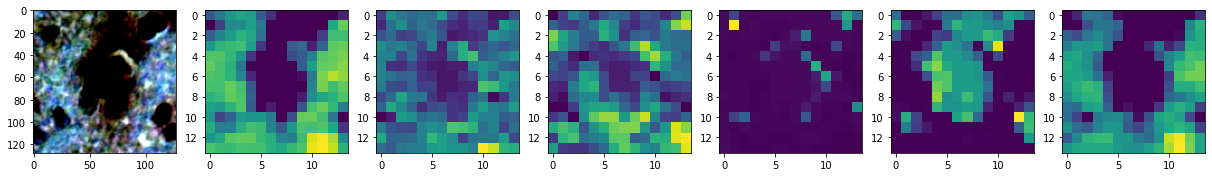

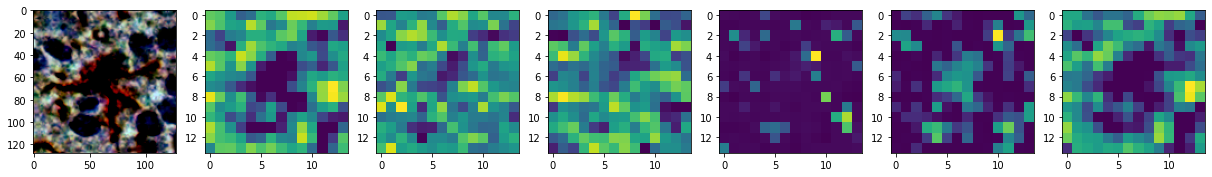

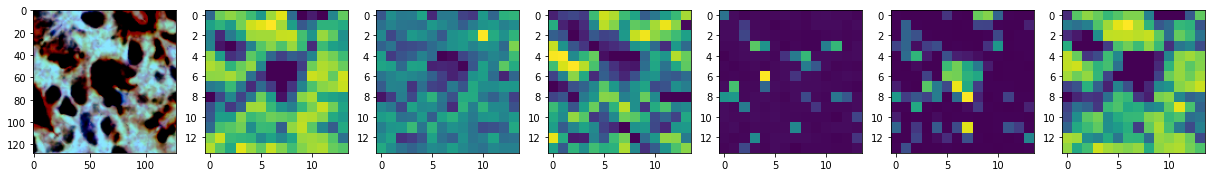

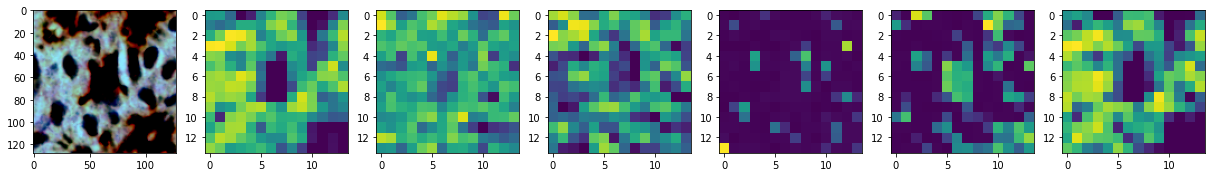

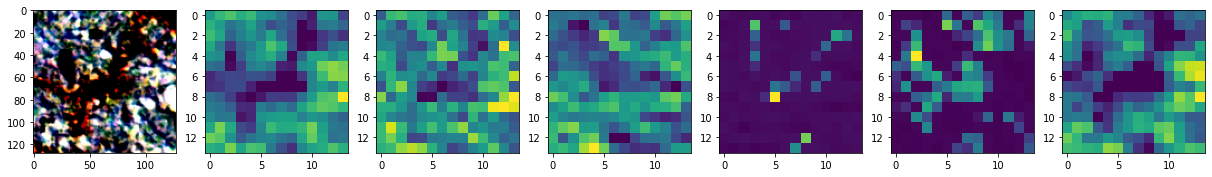

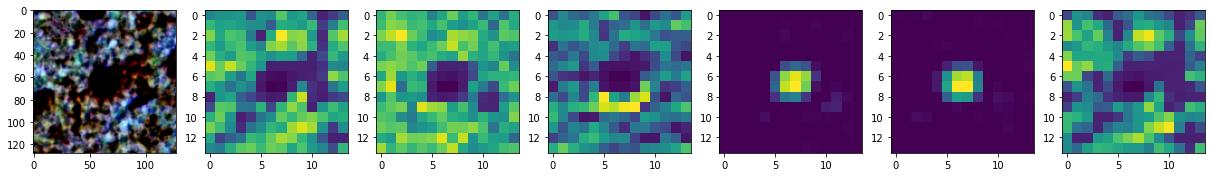

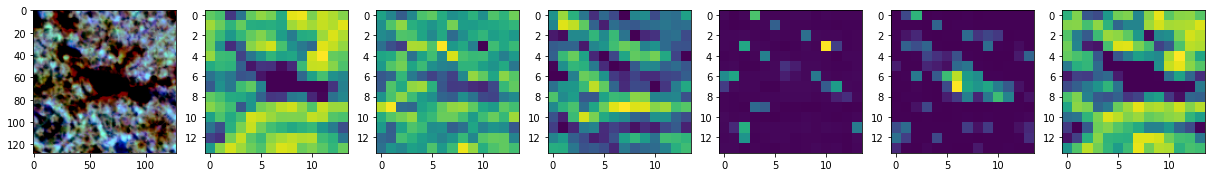

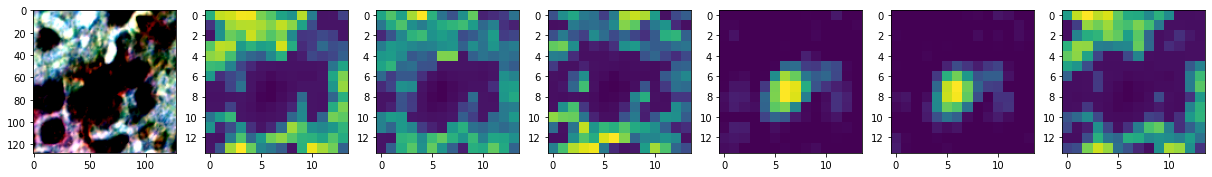

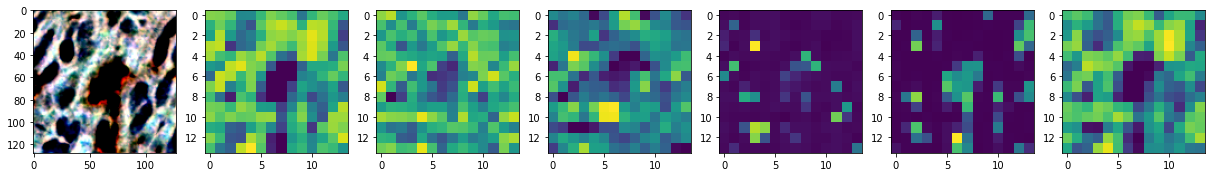

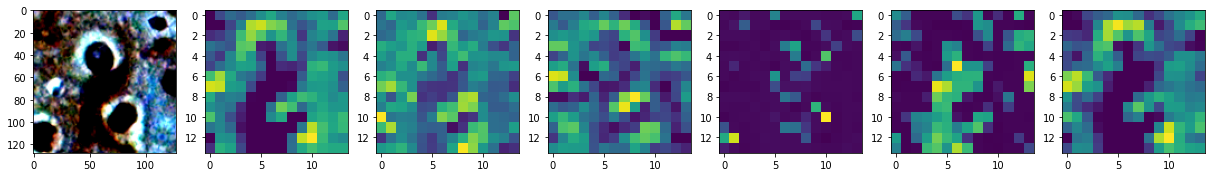

In [65]:
x, y = next(iter(data))
z = autoencoder(x.to(device))
c = autoencoder.encoder(x.to(device))

for i in range(10):
    fig, ax = plt.subplots(1, 7, figsize=(7*3,3))
    # fig, ax = plt.subplots(1, 4, figsize=(4*3,3))
    # Reshape the array for plotting
    plt.sca(ax[0])
    img = x[i].cpu().detach().numpy()
    # img = np.moveaxis(np.array([norm(im) for im in img]), 0, -1)
    # plt.imshow((img*255).astype(np.uint8))
    plt.imshow(np.moveaxis(img, 0, -1))
    
    
    # plt.sca(ax[1])
    # img = z[i].cpu().detach().numpy()
    # # img = un_z_score(img, avg, std)
    # img = np.moveaxis(img, 0, -1)
    # # img = np.moveaxis(np.array([norm(im) for im in img]), 0, -1)
    # plt.imshow(img)
    # # plt.imshow((img*255).astype(np.uint8))
    
    plt.sca(ax[1])
    plt.imshow(c[i].moveaxis(0, -1)[:,:,0:1].cpu().detach().numpy())
    
    plt.sca(ax[2])
    plt.imshow(c[i].moveaxis(0, -1)[:,:,1:2].cpu().detach().numpy())
    
    plt.sca(ax[3])
    plt.imshow(c[i].moveaxis(0, -1)[:,:,2:3].cpu().detach().numpy())
    
    plt.sca(ax[4])
    plt.imshow(c[i].moveaxis(0, -1)[:,:,3:4].cpu().detach().numpy())
    
    plt.sca(ax[5])
    plt.imshow(c[i].moveaxis(0, -1)[:,:,4:5].cpu().detach().numpy())
    
    plt.sca(ax[6])
    plt.imshow(c[i].moveaxis(0, -1)[:,:,6:7].cpu().detach().numpy())
    
#     plt.sca(ax[2])
#     plt.imshow(c[i].moveaxis(0, -1)[:,:,0:3].cpu().detach().numpy())
    
#     plt.sca(ax[3])
#     plt.imshow(c[i].moveaxis(0, -1)[:,:,3:6].cpu().detach().numpy())
    
#     plt.sca(ax[4])
#     plt.imshow(c[i].moveaxis(0, -1)[:,:,6:9].cpu().detach().numpy())
    
#     plt.sca(ax[5])
#     plt.imshow(c[i].moveaxis(0, -1)[:,:,9:12].cpu().detach().numpy())
    
#     plt.sca(ax[6])
#     plt.imshow(c[i].moveaxis(0, -1)[:,:,12:15].cpu().detach().numpy())
plt.savefig("/research/sharedresources/cbi/public/data/hackathon_data/K-means_of_conv_autoencoder_feature_latent_space.png")

In [23]:
outputs = np.zeros([0, 256])
labels = np.zeros(0)
autoencoder.eval()
for x, y in data_test:
    z = autoencoder.mlp_down(autoencoder.encoder(x.to(device)))
    z = z.reshape((len(z), -1))
    outputs = np.concatenate([outputs, z.cpu().detach().numpy()], axis=0)
    labels = np.concatenate([labels, y])

In [24]:
outputs.shape

(473, 256)

In [25]:
tsne = TSNE(n_components=2, learning_rate='auto', perplexity=10, n_iter=1000,
                   init='random').fit_transform(outputs)

In [26]:
tsne.shape

(473, 2)

/research/sharedresources/cbi/common/Anna/anaconda3/envs/quamd/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

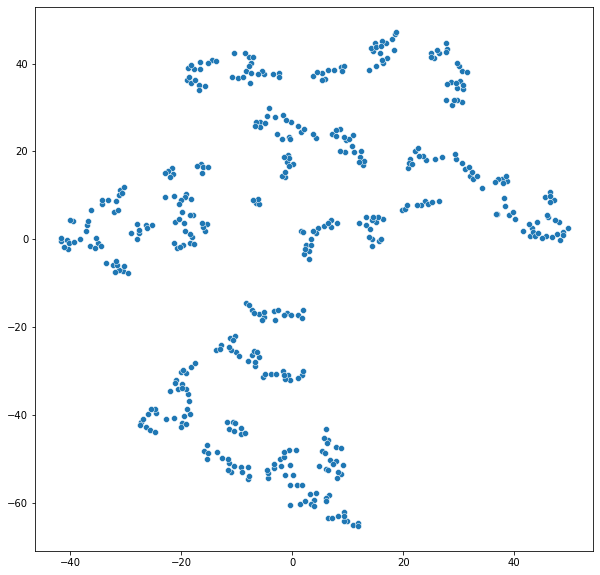

In [27]:
plt.figure(figsize=(10, 10))
sns.scatterplot(tsne[:,0], tsne[:,1])

In [28]:
from sklearn.cluster import KMeans

In [37]:
ncl = 12
kmeans = KMeans(n_clusters=ncl, random_state=0).fit(outputs)
labels = kmeans.labels_

In [38]:
import matplotlib.patheffects as PathEffects
def fashion_scatter(x, colors):
    """
    https://www.datacamp.com/community/tutorials/introduction-t-sne
    """
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

/tmp/ipykernel_1462533/3406033206.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])


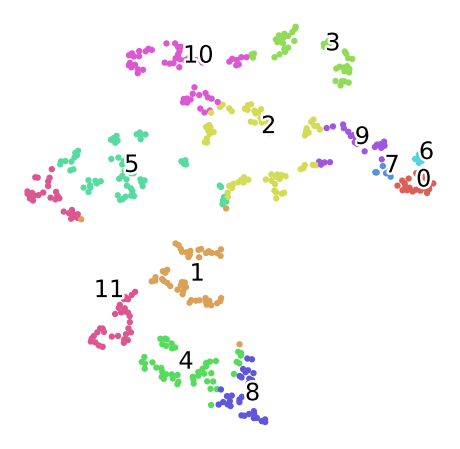

In [56]:
fashion_scatter(tsne, labels)
plt.savefig("/research/sharedresources/cbi/public/data/hackathon_data/K-means_of_conv_autoencoder_feature_tsne.png")

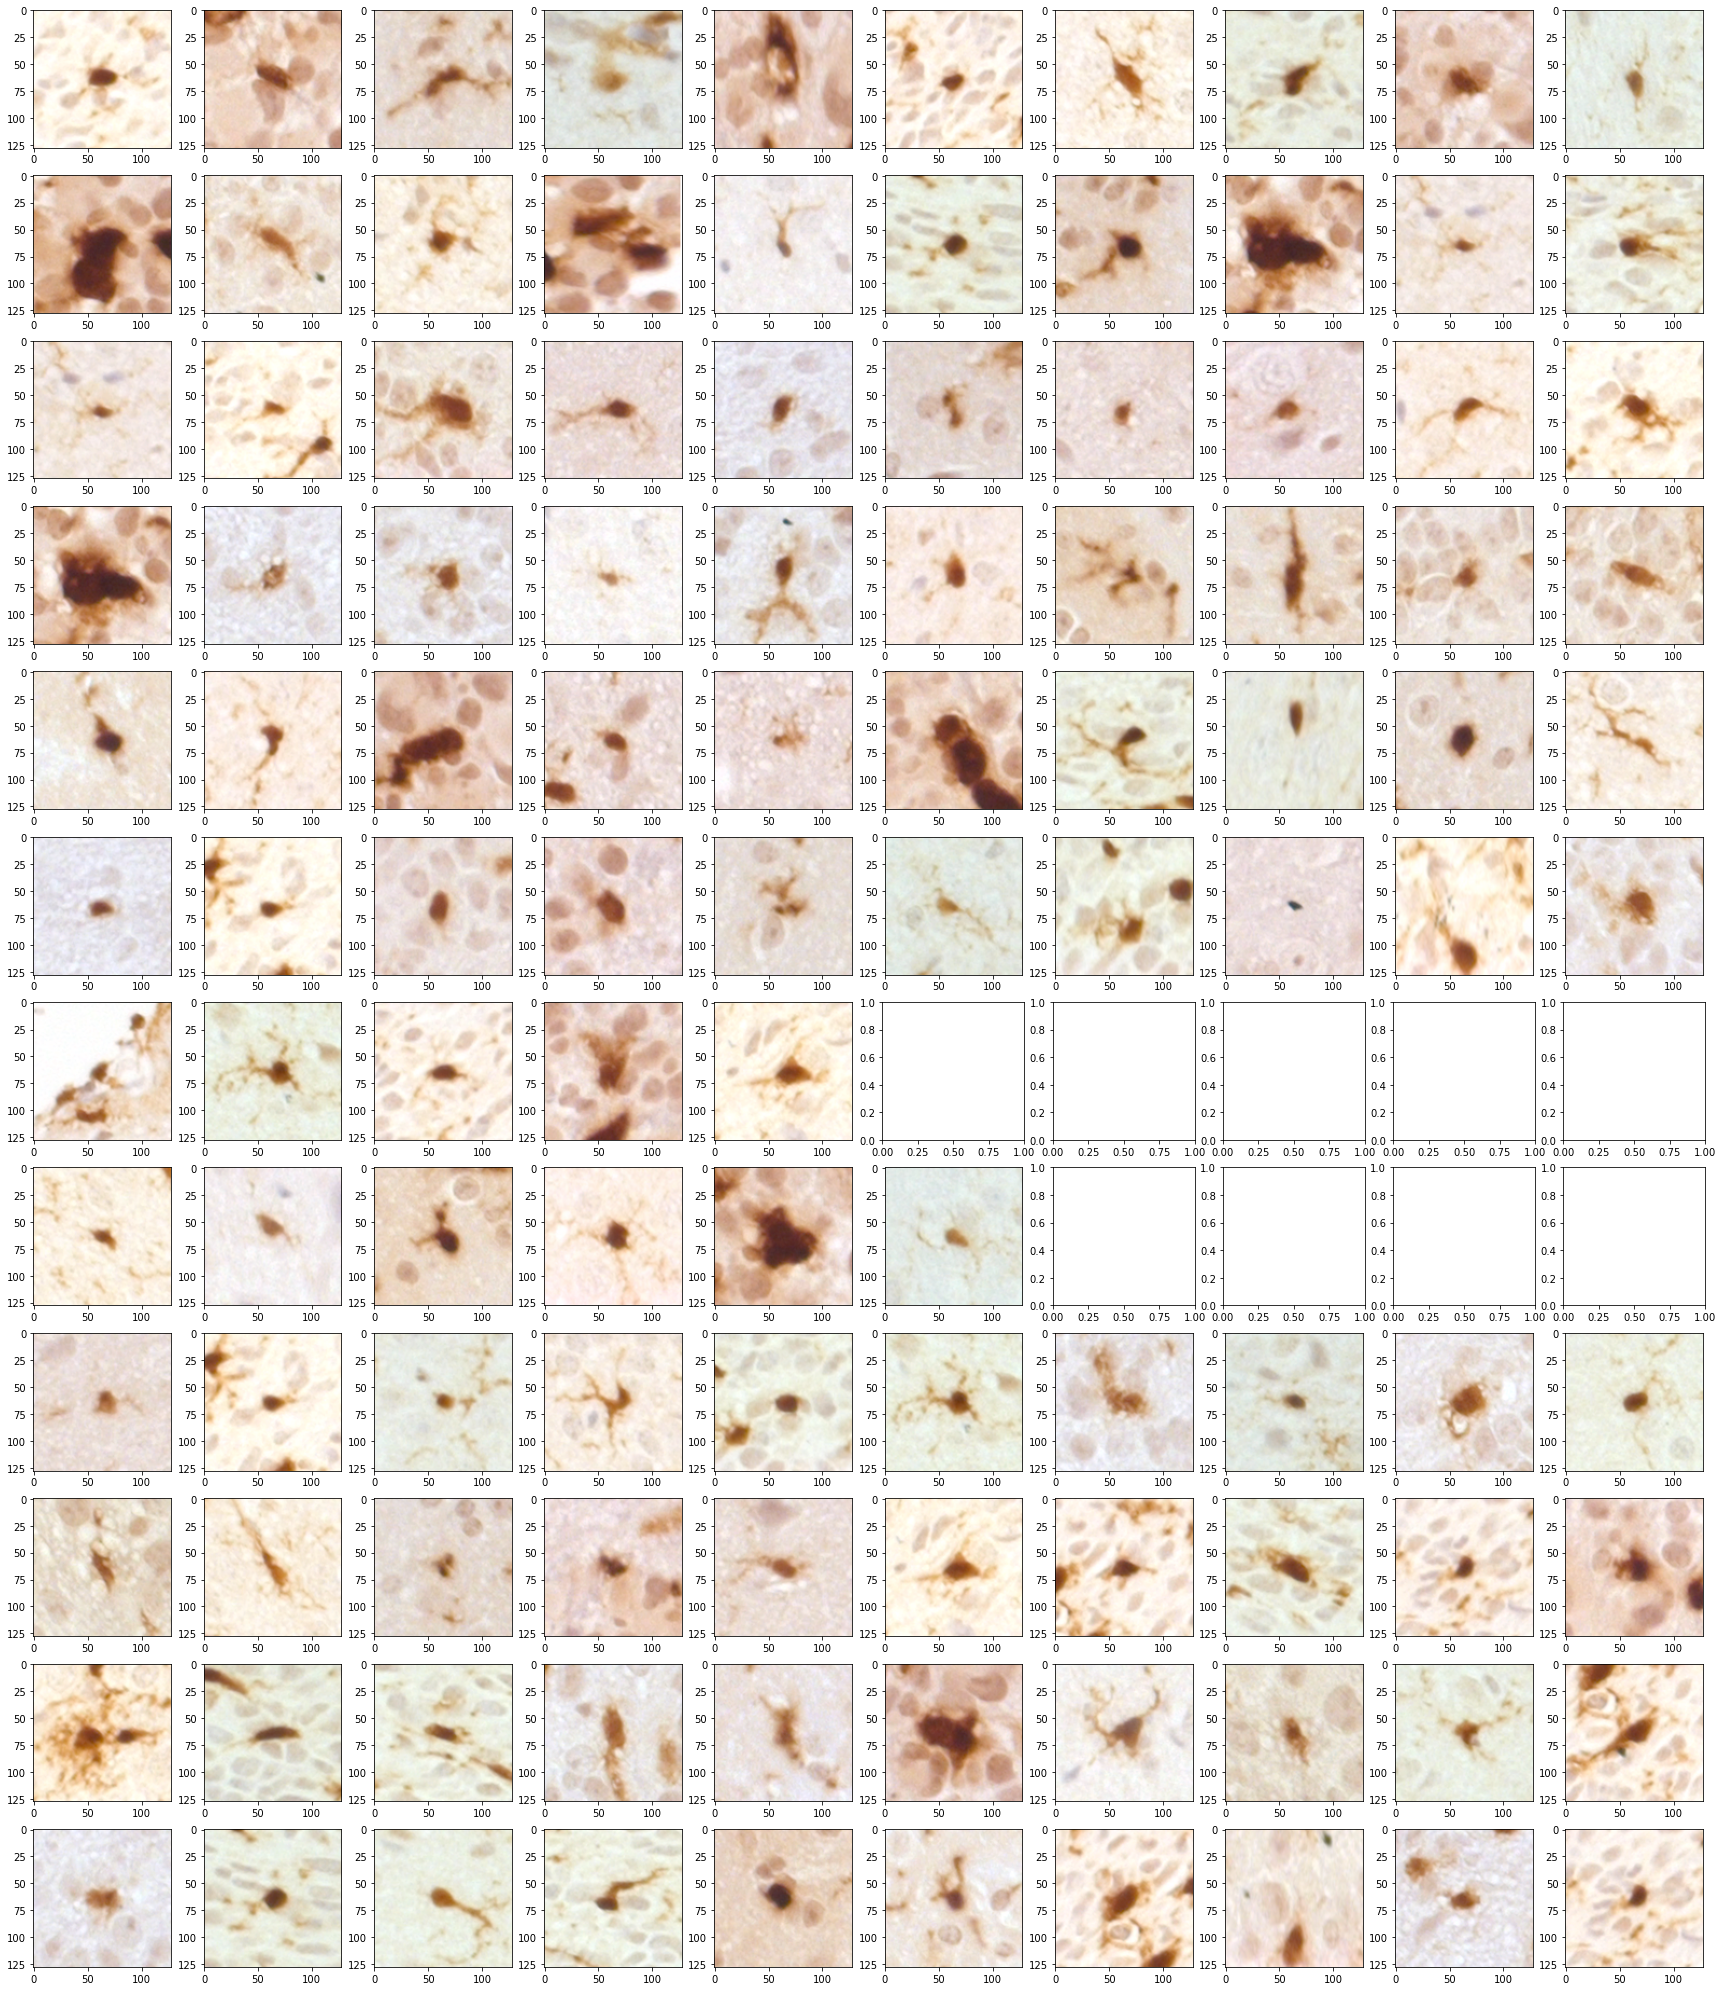

In [50]:
cols = 10
fig, ax = plt.subplots(ncl, cols, figsize=(cols*3,ncl*3))
# for l in [3,8,10,1,9,4,6,2,7,5,11,0]:
for l in np.unique(labels):
    ind = np.where(labels == l)
    cur_arr = arr[ind]
    imgs = cur_arr[np.random.choice(np.arange(len(cur_arr)), min(cols, len(cur_arr)), replace=False)]
    for j in range(len(imgs)):
        img = imgs[j]
        img = np.moveaxis(img, 0, -1)
        plt.sca(ax[l, j])
        plt.imshow(img)
plt.savefig("/research/sharedresources/cbi/public/data/hackathon_data/K-means_of_conv_autoencoder_feature.png")

In [51]:
path = "/research/sharedresources/cbi/public/data/hackathon_data/K-means_of_conv_autoencoder_feature_class_labels.npy"

In [54]:
np.save(path, labels)